In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [3]:
## What signals do we have?

print(df1.columns.values)

['DATETIME' 'L_T1' 'L_T2' 'L_T3' 'L_T4' 'L_T5' 'L_T6' 'L_T7' 'F_PU1'
 'S_PU1' 'F_PU2' 'S_PU2' 'F_PU3' 'S_PU3' 'F_PU4' 'S_PU4' 'F_PU5' 'S_PU5'
 'F_PU6' 'S_PU6' 'F_PU7' 'S_PU7' 'F_PU8' 'S_PU8' 'F_PU9' 'S_PU9' 'F_PU10'
 'S_PU10' 'F_PU11' 'S_PU11' 'F_V2' 'S_V2' 'P_J280' 'P_J269' 'P_J300'
 'P_J256' 'P_J289' 'P_J415' 'P_J302' 'P_J306' 'P_J307' 'P_J317' 'P_J14'
 'P_J422' 'ATT_FLAG']


In [4]:
## Finding correlation

correlation = df1.corr()
correlated_data= correlation
# correlation = correlation.abs()
correlation = correlation.unstack()
corr = correlation.sort_values(kind="quicksort",ascending=False)


## Autocorrelation
df1_columns = df1.columns.values.tolist()
df1_columns.remove('DATETIME')
df1_columns.remove('ATT_FLAG')
dw_stat = pd.Series(sm.stats.durbin_watson(df1[df1_columns]))

c:\users\martijn\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\stattools.py:47: RuntimeWarning: invalid value encountered in true_divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


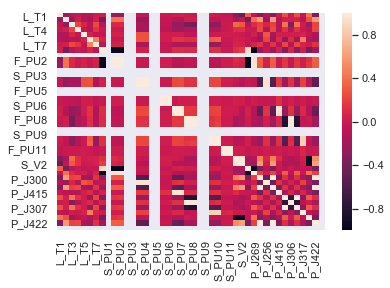

In [5]:
## Heatmap all signals

sns.heatmap(correlated_data)

In [6]:
## Sort correlation for later use

corr = corr.to_frame().reset_index()
corr.columns = ["1","2","correlation"]

corr = corr[corr["correlation"] != 1]
corr = corr[corr["1"] != "ATT_FLAG"]
corr = corr.dropna()


In [7]:
correlheat = correlated_data

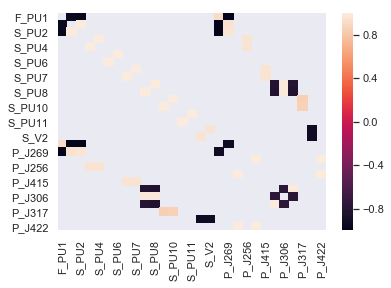

In [8]:
## Plot only most correlated values

correlheat = correlheat.drop("ATT_FLAG",axis=1)
correlheat = correlheat[correlheat != 1]
correlheat = correlheat[abs(correlheat) > 0.7]
correlheat = correlheat.dropna(axis=1,how="all")
correlheat = correlheat.dropna(axis=0, how ="all")
sns.heatmap(correlheat)

In [9]:
## Show most correlated signals
corr.head()

,1,2,correlation
36,P_J302,P_J307,0.999962
37,P_J307,P_J302,0.999962
38,F_PU6,S_PU6,0.999887
39,S_PU6,F_PU6,0.999887
40,P_J289,P_J300,0.999858


In [10]:
idx = len(df1) - 1 if len(df1) % 24 else len(df1)
test = df1[:idx].groupby(df1.index[:idx] // 24).mean()

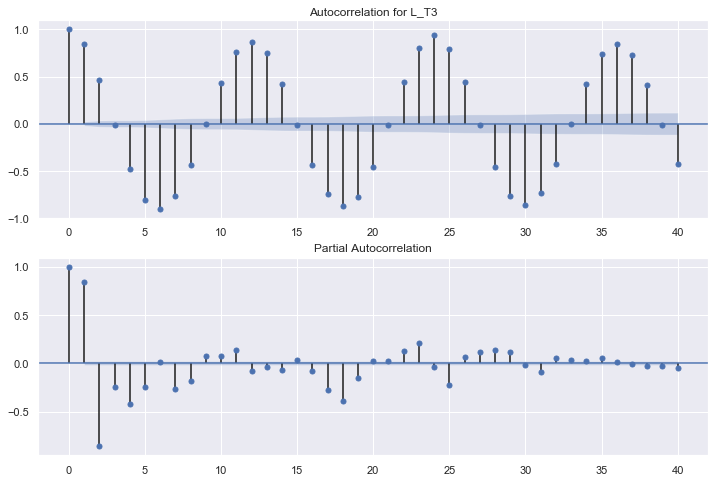

In [78]:
## Plot autocorrelations -> wow, it is cyclic :0

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
testvariable = "L_T3"
fig = sm.graphics.tsa.plot_acf(df1[testvariable].values.squeeze(), lags=40, ax=ax1,title = "Autocorrelation for {}".format(testvariable))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1[testvariable], lags=40, ax=ax2)

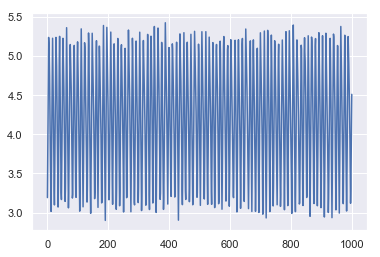

In [12]:
## Again show the cyclic behaviour 
sns.lineplot(data=df1["L_T3"][0:1000])

In [13]:
df1.columns

Index(['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')

In [14]:
len(df1.columns)

45

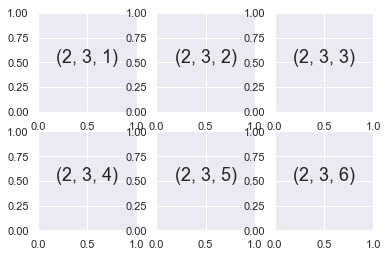

In [15]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')


In [16]:
def create_sliding(small_df, slide_size):
    column_names = small_df.columns.values.tolist()
    feature_df = pd.DataFrame(columns=[x + '_' + str(i) for x in column_names for i in range(slide_size)])
    target_df = pd.DataFrame(columns=[x + '_goal' for x in column_names])
    
    target_df = small_df.iloc[sliding_width:, :].copy().reset_index(drop=True)
    
    
    for offset in range(len(small_df)-slide_size):
        for x in range(slide_size):
            feature_df.loc[offset, [clm + '_' + str(x) for clm in column_names]] = small_df.iloc[offset+x, :].values
    return feature_df, target_df

In [30]:
## Predicting the next value
## We will use sliding windows 

sliding_width = 10
small_df = df1.iloc[:10000, :]    
feature_df, target_df = create_sliding(small_df.loc[:,['L_T1']], sliding_width)

In [31]:
feature_df

,L_T1_0,L_T1_1,L_T1_2,L_T1_3,L_T1_4,L_T1_5,L_T1_6,L_T1_7,L_T1_8,L_T1_9
0,0.50973,0.41258,0.320112,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654
1,0.41258,0.320112,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855
2,0.320112,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065
3,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482
4,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396
5,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369
6,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158
7,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158,1.45462
8,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158,1.45462,1.53166
9,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158,1.45462,1.53166,1.6626


In [32]:
from sklearn.neural_network import MLPRegressor


In [33]:
## Train an MLP on the windows

classifier = MLPRegressor()
classifier.fit(feature_df.iloc[:int(len(feature_df)/2)+1, :], target_df.loc[:int(len(feature_df)/2), 'L_T1'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
feature_df

,L_T1_0,L_T1_1,L_T1_2,L_T1_3,L_T1_4,L_T1_5,L_T1_6,L_T1_7,L_T1_8,L_T1_9
0,0.50973,0.41258,0.320112,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654
1,0.41258,0.320112,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855
2,0.320112,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065
3,0.332879,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482
4,0.483496,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396
5,0.791114,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369
6,1.18659,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158
7,1.42045,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158,1.45462
8,1.53483,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158,1.45462,1.53166
9,1.57654,1.55855,1.48065,1.46482,1.48396,1.38369,1.35158,1.45462,1.53166,1.6626


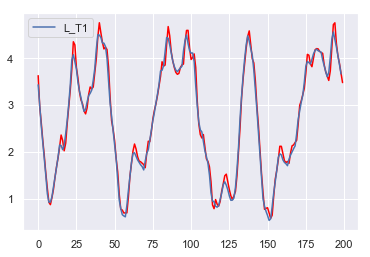

In [38]:
## Plot the predictions and targets

fig, ax = plt.subplots()
sns.lineplot(data=classifier.predict(feature_df.loc[int(len(feature_df)/2+1):int(len(feature_df)/2+200), :]), ax=ax, color="red")
sns.lineplot(data=target_df.iloc[int(len(feature_df)/2+1):int(len(feature_df)/2+200), :].reset_index(drop=True), ax=ax)